## Bayesian Methods Course Project

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import scipy.stats as stats
import pymc3 as pm
import arviz as az
import seaborn as sns
from sklearn.metrics import roc_auc_score
az.style.use('arviz-darkgrid')
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 300)
pd.set_option('display.max_rows', 300)
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split,GridSearchCV,StratifiedKFold,RandomizedSearchCV,cross_val_score
from sklearn.metrics import confusion_matrix, classification_report
from scipy.stats import logistic
SEED = 43

### Data Exploration and Preparation

***Features***: 
- **enrollee_id**: Unique ID for candidate
- **city**: City code
- **city_ development _index**: Developement index of the city (scaled)
- **gender**: Gender of candidate
- **relevent_experience**: Relevant experience of candidate
- **enrolled_university**: Type of University course enrolled if any
- **education_level**: Education level of candidate
- **major_discipline** :Education major discipline of candidate
- **experience**: Candidate total experience in years
- **company_size**: No of employees in current employer's company
- **company_type**: Type of current employer
- **lastnewjob**: Difference in years between previous job and current job
- **training_hours**: training hours completed  


***Target***: 
- 0 – Not looking for job change, 
- 1 – Looking for a job change


In [2]:
df = pd.read_csv('../input/hr-analytics-job-change-of-data-scientists/aug_train.csv', sep = ',')
df.head()

,enrollee_id,city,city_development_index,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job,training_hours,target
0,8949,city_103,0.920,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,NaN,NaN,1,36,1.0
1,29725,city_40,0.776,Male,No relevent experience,no_enrollment,Graduate,STEM,15,50-99,Pvt Ltd,>4,47,0.0
2,11561,city_21,0.624,NaN,No relevent experience,Full time course,Graduate,STEM,5,NaN,NaN,never,83,0.0
3,33241,city_115,0.789,NaN,No relevent experience,NaN,Graduate,Business Degree,<1,NaN,Pvt Ltd,never,52,1.0
4,666,city_162,0.767,Male,Has relevent experience,no_enrollment,Masters,STEM,>20,50-99,Funded Startup,4,8,0.0


In [3]:
df.drop(['enrollee_id'], axis = 1, inplace = True)

In [4]:
df.shape

(19158, 13)

In [5]:
df.describe(include = 'object')

,city,gender,relevent_experience,enrolled_university,education_level,major_discipline,experience,company_size,company_type,last_new_job
count,19158,14650,19158,18772,18698,16345,19093,13220,13018,18735
unique,123,3,2,3,5,6,22,8,6,6
top,city_103,Male,Has relevent experience,no_enrollment,Graduate,STEM,>20,50-99,Pvt Ltd,1
freq,4355,13221,13792,13817,11598,14492,3286,3083,9817,8040


Text(0.5, 1.0, 'Target distribution')

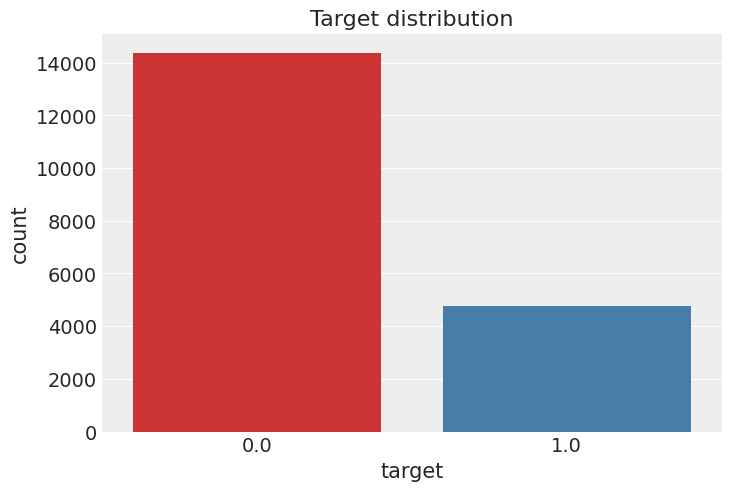

In [6]:
sns.countplot('target',data = df, palette = 'Set1')
plt.title('Target distribution')

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  14650 non-null  object 
 3   relevent_experience     19158 non-null  object 
 4   enrolled_university     18772 non-null  object 
 5   education_level         18698 non-null  object 
 6   major_discipline        16345 non-null  object 
 7   experience              19093 non-null  object 
 8   company_size            13220 non-null  object 
 9   company_type            13018 non-null  object 
 10  last_new_job            18735 non-null  object 
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  float64
dtypes: float64(2), int64(1), object(10)
memory usage: 1.9+ MB


Let's take a look at the number of missing values, there are quite a few of them, so we will create a new category and fill in the gaps with it

Text(0.5, 1.0, 'Number of NaN values')

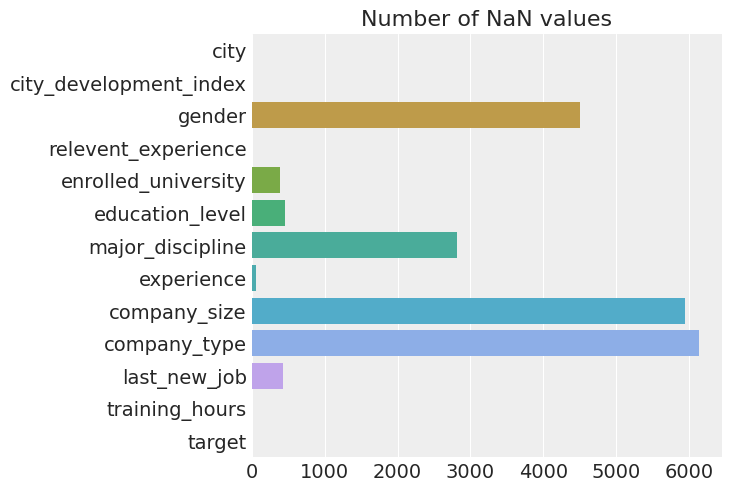

In [8]:
sns.barplot(y = df.columns ,  x=df.isnull().sum().values)
plt.title('Number of NaN values')

Fill missing values

In [9]:
df = df.fillna('None')

To avoid dummy variable trap, which occurs due to multicollinearity in the variables when we include one dummy variable per category for categoric variables - which is exactly what OneHotEncoder does! So exclude one variable

In [10]:
df = pd.get_dummies(df, prefix = ['city'], columns = ['city'], drop_first=True)
df = pd.get_dummies(df, prefix = ['gender'], columns = ['gender'], drop_first=True)
df = pd.get_dummies(df, prefix = ['re'], columns = ['relevent_experience'], drop_first=True)
df = pd.get_dummies(df, prefix = ['enu'], columns = ['enrolled_university'], drop_first=True)
df = pd.get_dummies(df, prefix = ['edul'], columns = ['education_level'], drop_first=True)
df = pd.get_dummies(df, prefix = ['md'], columns = ['major_discipline'], drop_first=True)
df = pd.get_dummies(df, prefix = ['exper'], columns = ['experience'], drop_first=True)
df = pd.get_dummies(df, prefix = ['compsize'], columns = ['company_size'], drop_first=True)
df = pd.get_dummies(df, prefix = ['comptype'], columns = ['company_type'], drop_first=True)
df = pd.get_dummies(df, prefix = ['lnj'], columns = ['last_new_job'], drop_first=True) 
bins = np.linspace(df['training_hours'].min(), df['training_hours'].max(), 20 ) # binning
which_bin = np.digitize(df['training_hours'], bins = bins)
df['training_hours'] = which_bin
df = pd.get_dummies(df, prefix = ['trainhour'], columns = ['training_hours'], drop_first=True)                                                                                      #binning                  

In [11]:
df.shape

(19158, 203)

In [12]:
y  = df['target'].values
df.drop(['target'], axis = 1, inplace=True)
X = df.values

In [13]:
X = np.hstack([np.ones(shape=(X.shape[0], 1)), X])
X[:5]

array([[1.   , 0.92 , 0.   , ..., 0.   , 0.   , 0.   ],
       [1.   , 0.776, 0.   , ..., 0.   , 0.   , 0.   ],
       [1.   , 0.624, 0.   , ..., 0.   , 0.   , 0.   ],
       [1.   , 0.789, 0.   , ..., 0.   , 0.   , 0.   ],
       [1.   , 0.767, 0.   , ..., 0.   , 0.   , 0.   ]])

Train/Test split in ratio of  80 to 20

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                                random_state=SEED, stratify = y, shuffle = True )

### Simple Maximum Likelihood Estimation 

In order to chose values for the parameters of logistic regression, we use maximum likelihood estimation (MLE)

In [15]:
model = LogisticRegression(fit_intercept=False)

Сhoose the regularization parameter

In [16]:
parameters = {
    'C': np.linspace(0.01,1,100)
}

In [17]:
cv = StratifiedKFold(n_splits = 3,shuffle = True, random_state=SEED)

In [18]:
gcv = GridSearchCV(estimator = model, param_grid = parameters, cv = cv, verbose = 10,scoring = 'roc_auc', n_jobs = -1)

In [19]:
gcv.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=7, shuffle=True),
             estimator=LogisticRegression(fit_intercept=False), n_jobs=-1,
             param_grid={'C': array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
       0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
       0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
       0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
       0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
       0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
       0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
       0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
       0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99,
       1.  ])},
             scoring='roc_auc', verbose=10)

In [20]:
gcv.best_params_

{'C': 0.3}

In [21]:
y_pred = gcv.predict_proba(X_test)[:,1]
metric = roc_auc_score(y_test, y_pred)
metric

0.7794497613315209

### MCMC approach
Model:

$$
\begin{equation*} \begin{cases}
 t_i | x_i, \mathbf w \sim \mathrm{Be}(\theta(\mathbf x_i)), \quad i = 1, \ldots, n \\
 \theta(x) = \mathrm{logit}(\mathbf w^T \mathbf x), \\
 \mathbf w_j \sim \mathcal{N}(0 ,\,\sigma_j^{2}),\quad j = 1, \ldots, d
\end{cases} \end{equation*}
$$

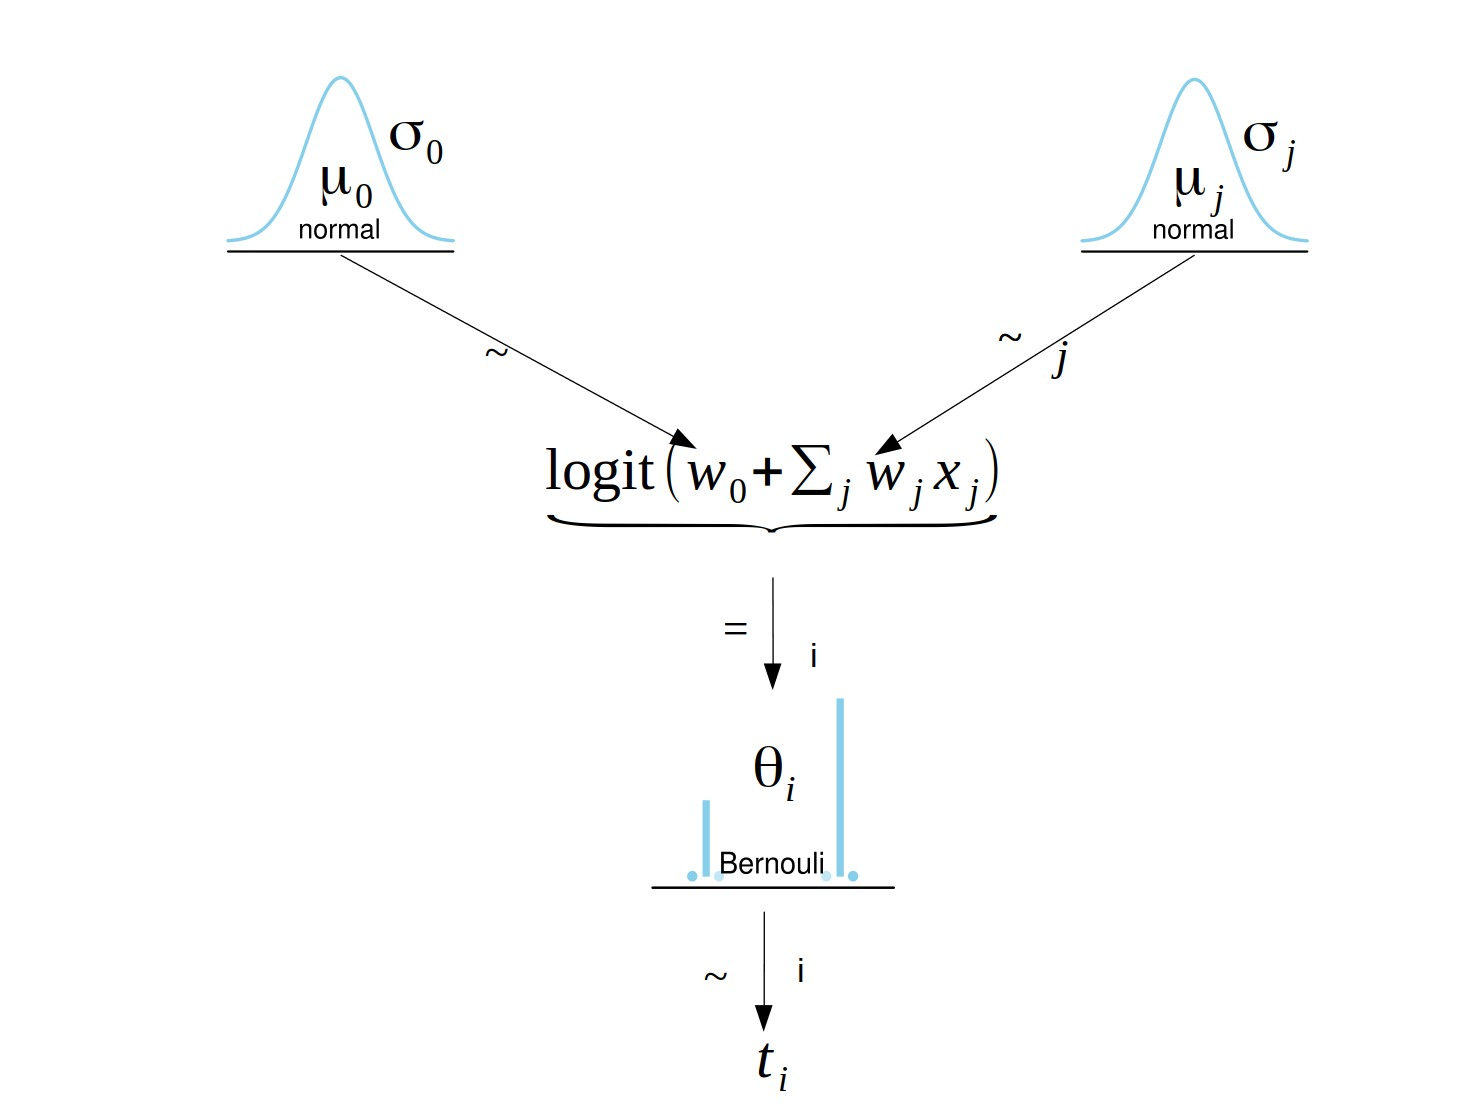

In [22]:
from IPython.display import Image
Image("../input/diagram/diagram.jpg")

Configuring our model - actually, the numerator of the posterior distribution

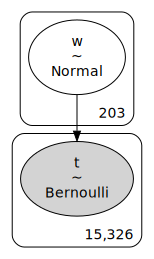

In [23]:
with pm.Model() as pm_model:
    w = pm.Normal('w', mu=0, sd=np.array([2] + (X_train.shape[1]-1)*[1]), shape= X_train.shape[1])  # sd=2 for w0 and sd=1 for predictors
    theta = pm.invlogit(pm.math.dot(w, X_train.T))
    outputs = pm.Bernoulli('t', theta, observed=y_train)
    
pm.model_to_graphviz(pm_model)

In [24]:
with pm_model:
    inf_data = pm.sample(draws = 2000,tune = 1000, chains = 2,cores = 4, return_inferencedata = True, random_seed = 55)

In [25]:
inf_data.posterior['w'].shape # 2 chains, 2000 draws, 203 parameters (wights)

(2, 2000, 203)

It can be seen that if you divide the plot into two parts, then they seem to be indistinguishable. In other words, the trace plot wanders around a common mean and its variance is almost constant over time. 

We run two chains and trace plots look statistically indistinguishable - a necessary condition for the MC to converge to a stationary distribution. 

For convenience, we will display only a part of more than 200 plots. 

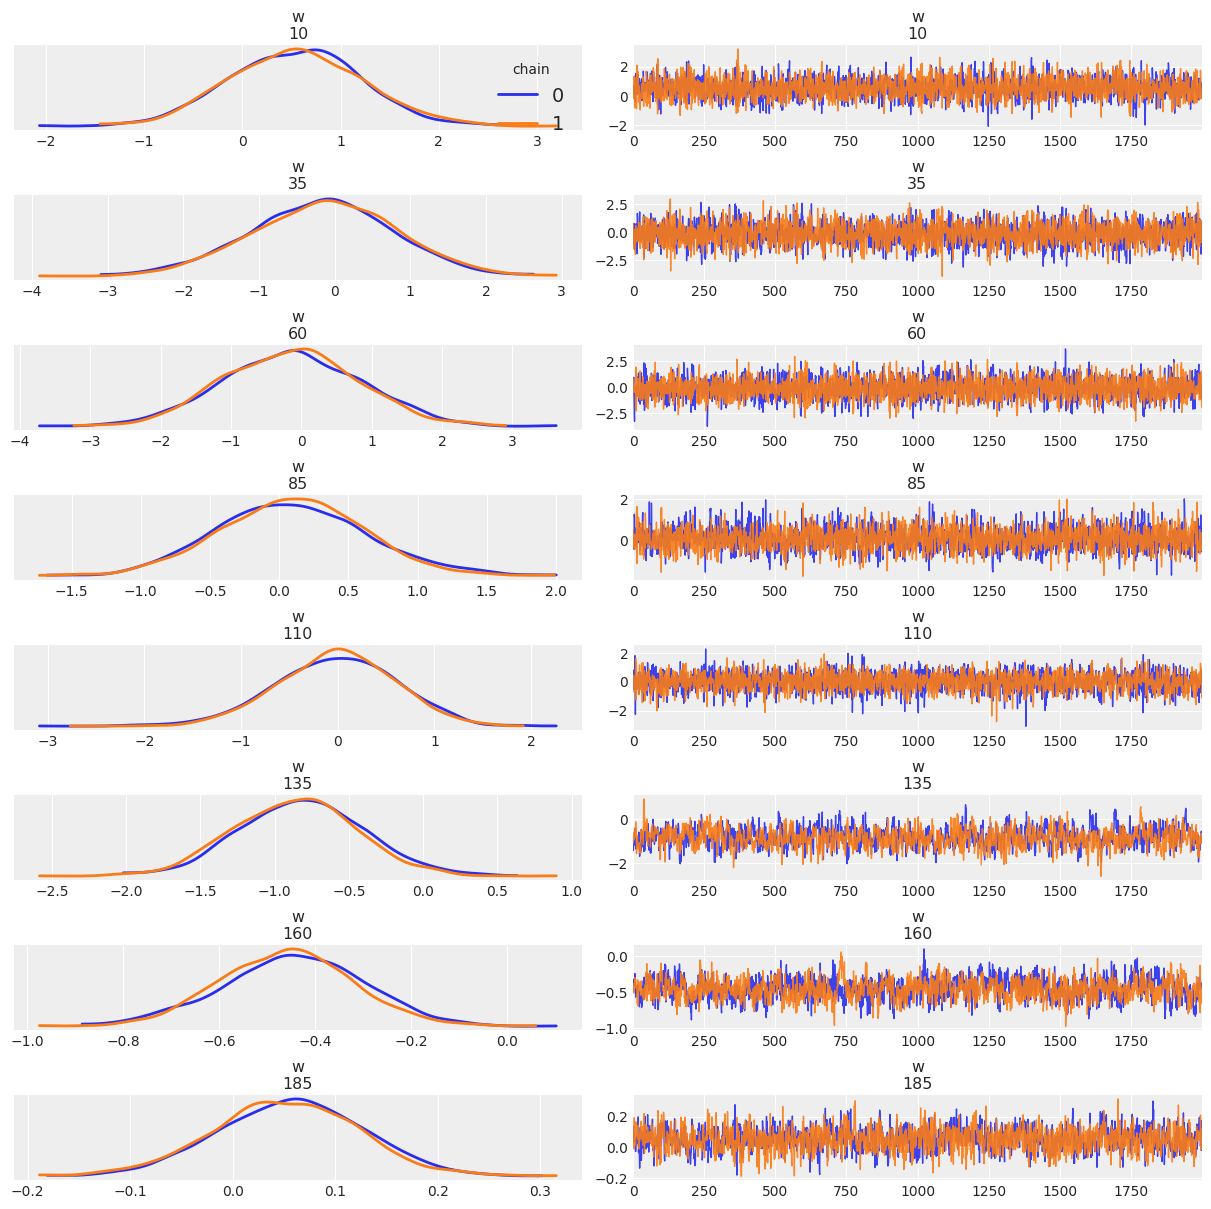

In [26]:
az.plot_trace(inf_data.posterior['w'][:,:,10::25],legend=True, figsize=(12,12),
              trace_kwargs={'linewidth' : 1,
                            'alpha' : 0.9},
              plot_kwargs={'linewidth' : 2,
                           'alpha' : 1},
              compact = False
             )
plt.show()

There is less information in a sample with autocorrelation than in a sample of the same size without autocorrelation. Therefore, given a sample of a certain size with a certain degree of autocorrelation, we could try to estimate what the sample size would be with the same information without autocorrelation. This number will be the effective sample size. 

As we can see, there is autocorrelation, given that the NUTS sampler is automatically assigned, but it is not very large so samples will allow us to make meaningful predictions

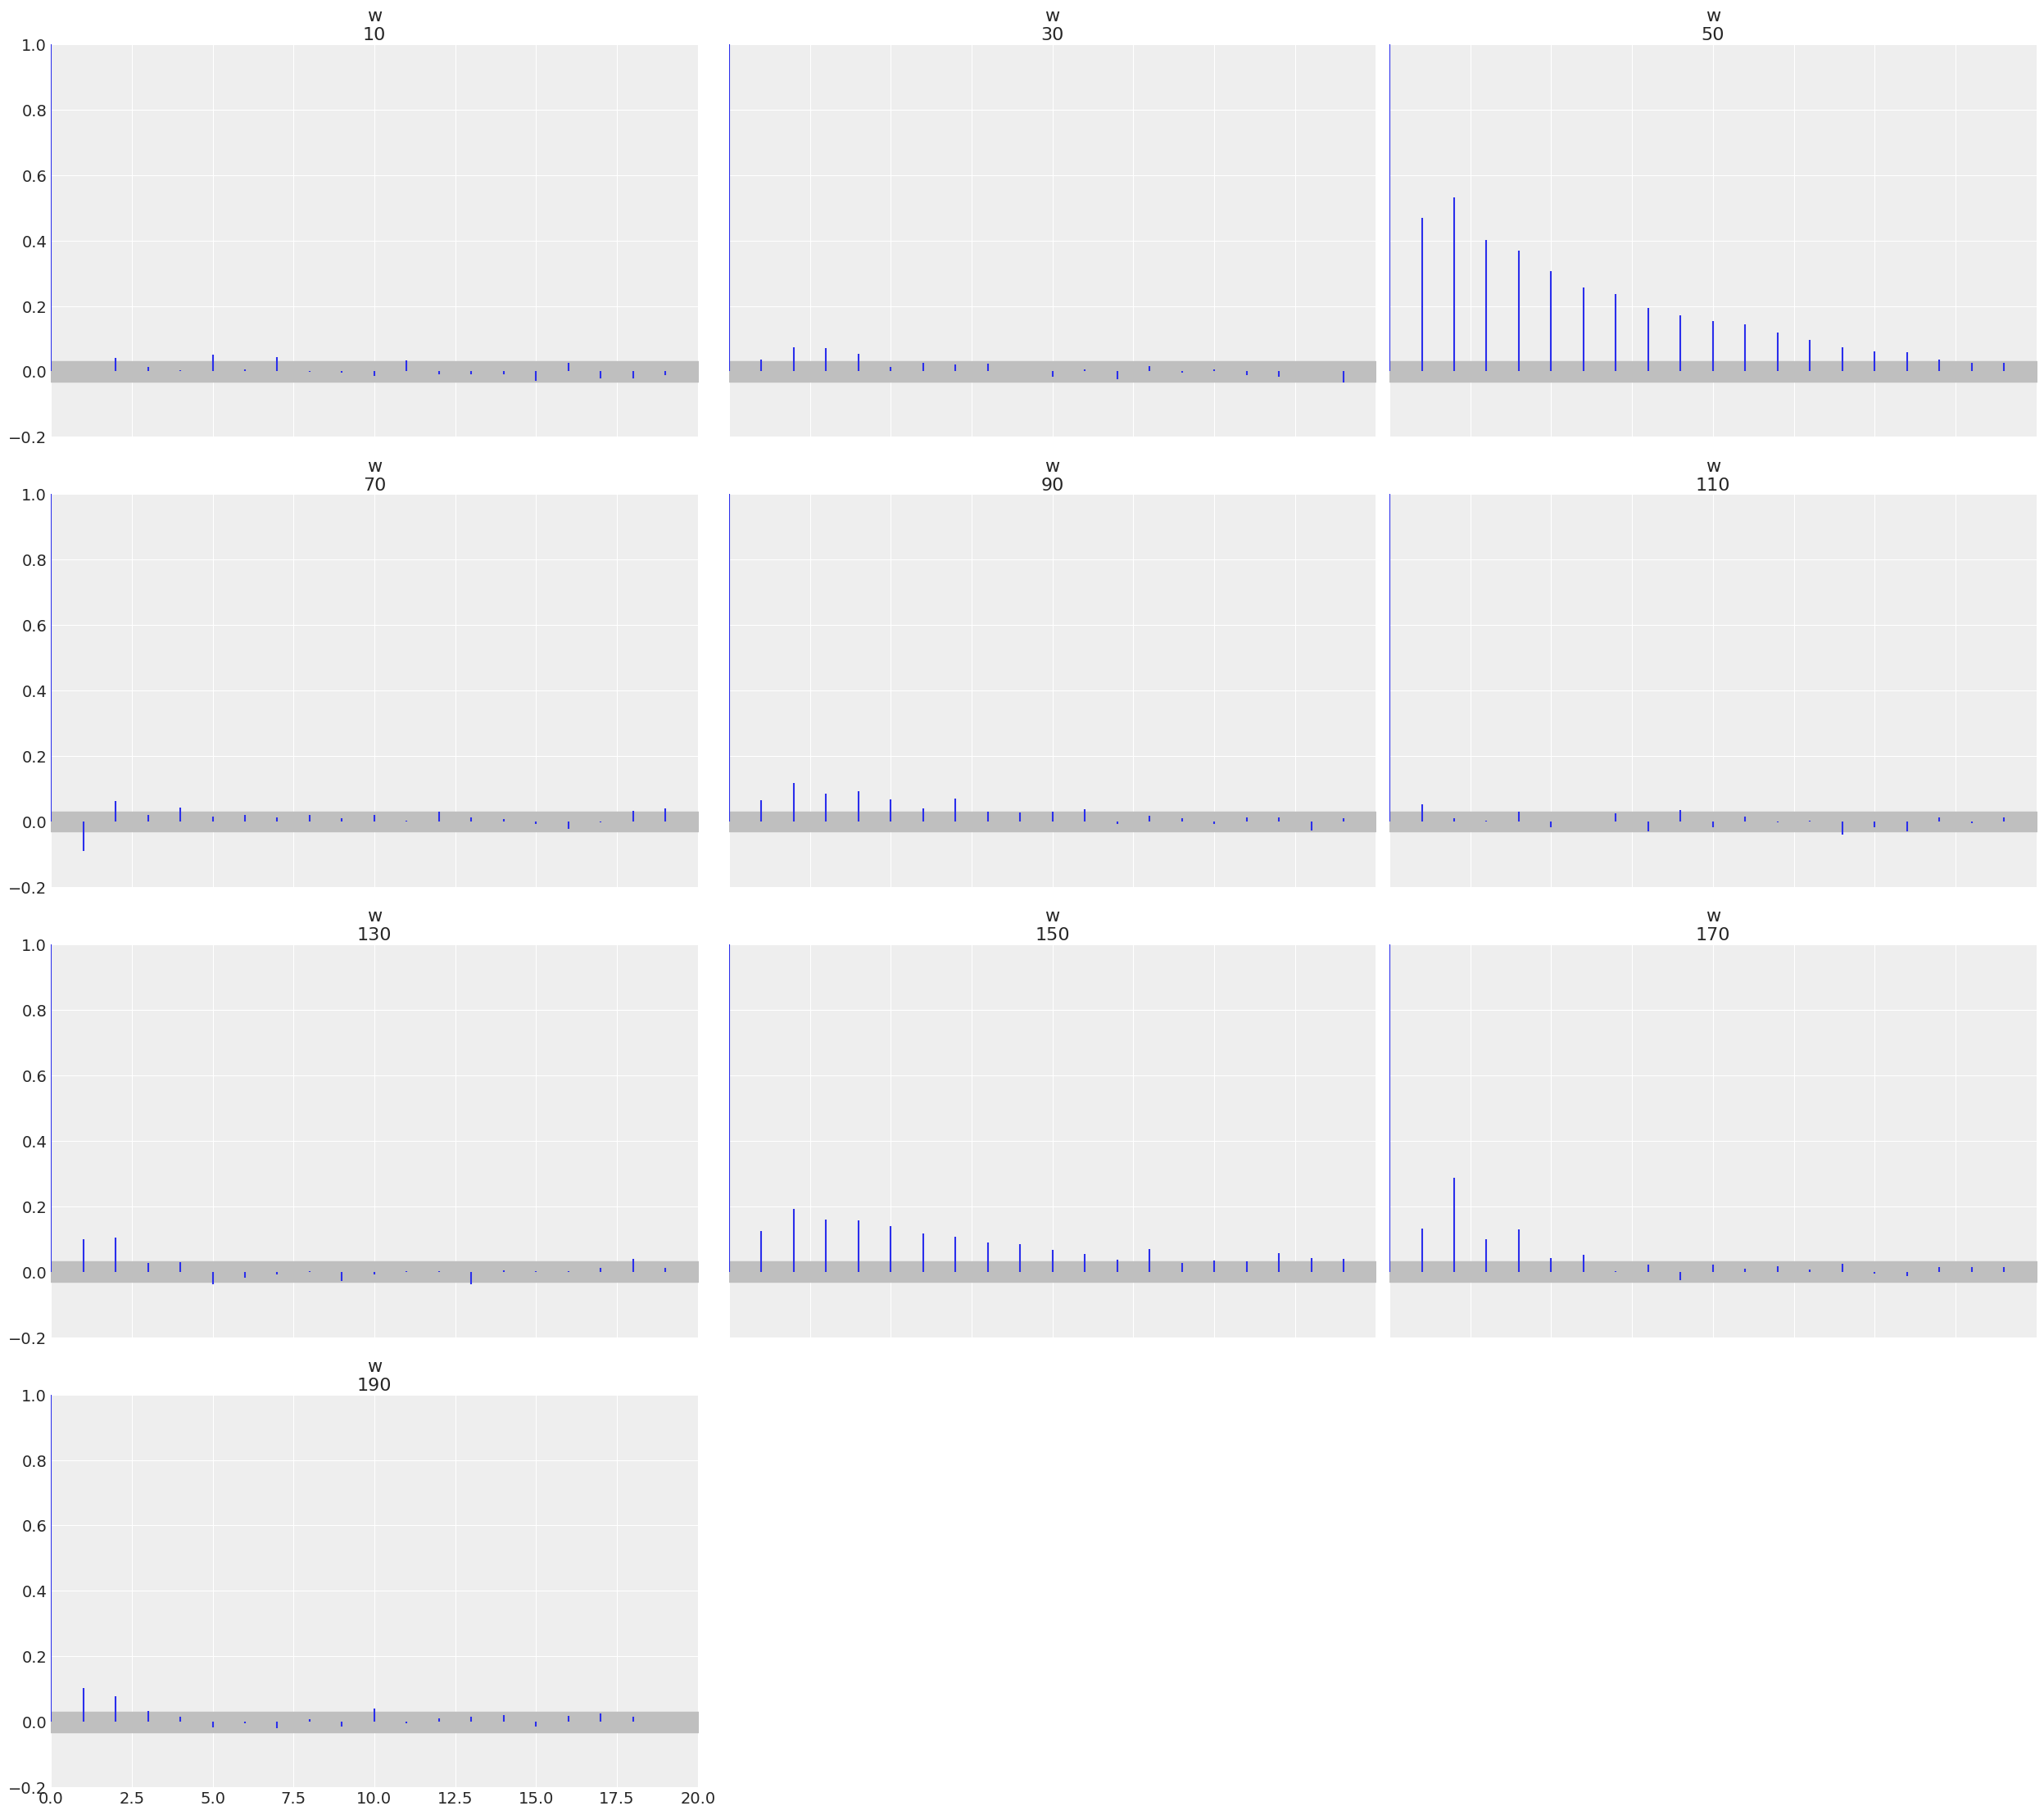

In [27]:
az.plot_autocorr(inf_data.posterior['w'][:,:,10::20], max_lag = 20, combined = True)
plt.ylim([-0.2, 1]);

A quantitative way to check for convergence is by using the Gelman-Rubin test. The idea of this test is to compare the variance between chains with the variance within chains. Ideally, we should expect a value of r_hat = 1. As an empirical rule, we will be ok with a value below 1.1, higher values are signaling a lack of convergence:

In [28]:
az.summary(inf_data, round_to = 2).head(10)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
w[0],0.84,0.49,-0.09,1.74,0.02,0.02,416.35,892.63,1.01
w[1],-2.56,0.59,-3.62,-1.41,0.03,0.02,374.15,698.35,1.01
w[2],-0.24,0.40,-0.98,0.52,0.01,0.01,2405.24,2450.19,1.00
w[3],0.41,0.22,0.03,0.84,0.01,0.01,854.15,1774.37,1.00
w[4],0.89,0.31,0.34,1.49,0.01,0.01,1082.06,2068.39,1.00
w[5],-0.38,0.22,-0.81,-0.00,0.01,0.00,1130.63,1829.19,1.00
w[6],0.45,0.15,0.17,0.74,0.01,0.01,368.26,641.98,1.01
w[7],-0.35,0.26,-0.86,0.10,0.01,0.01,931.55,1453.78,1.00
w[8],-0.63,0.37,-1.31,0.09,0.01,0.00,3160.91,2523.86,1.00
w[9],-0.53,0.75,-1.94,0.85,0.01,0.01,2969.52,2656.85,1.00


In [29]:
pd.DataFrame(az.summary(inf_data, round_to = 2))[['r_hat', 'ess_bulk', 'ess_tail']]\
    .apply(lambda x: [np.min(x), np.max(x), np.mean(x)] ).rename(index = {0 : 'min', 1: 'max', 2: 'mean'})

,r_hat,ess_bulk,ess_tail
min,1.000000,368.260000,641.980000
max,1.010000,6035.760000,3467.860000
mean,1.000887,2372.764581,2275.549557


the mean and minimum values ​​of the estimates of the effective samples size are quite good so sample will allow us to estimate the characteristics of the target distribution

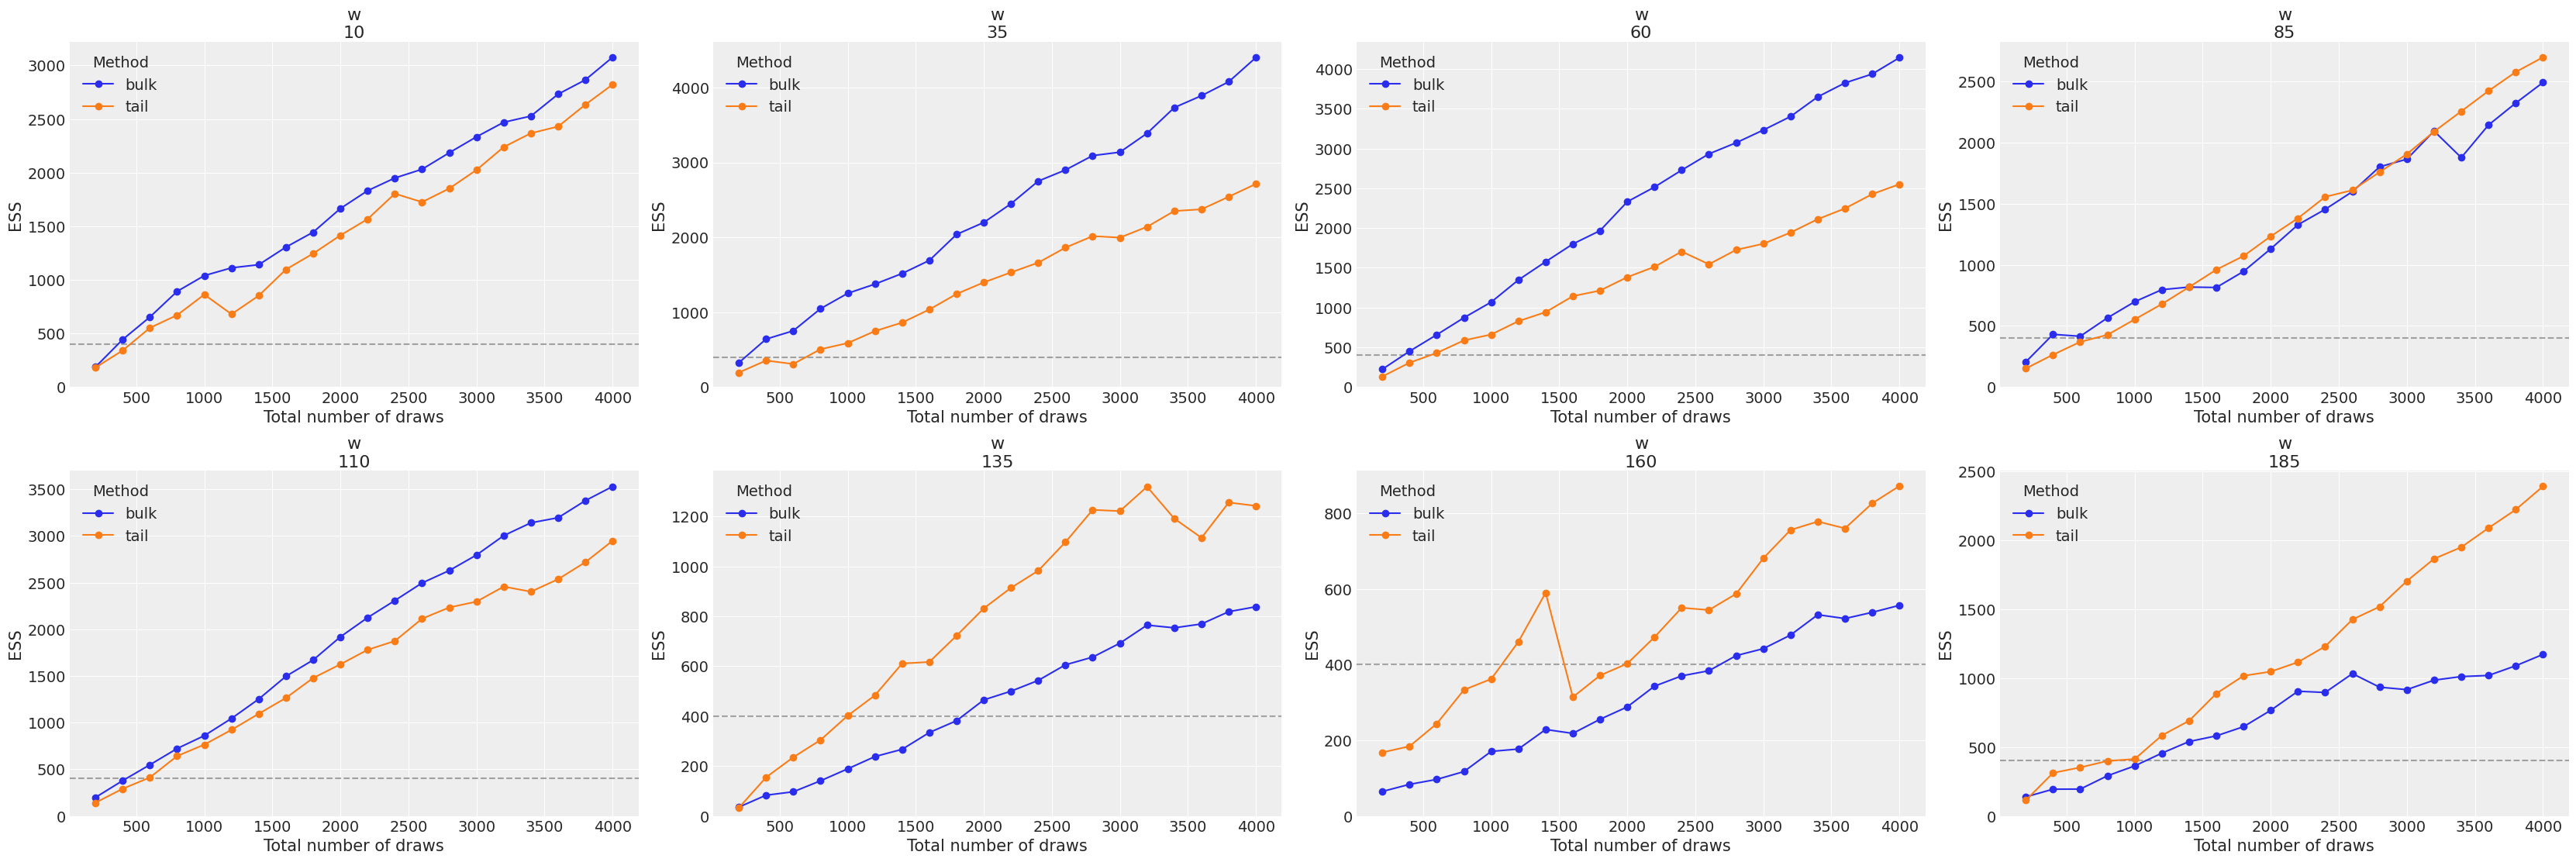

In [30]:
az.plot_ess(inf_data.posterior['w'][:,:,10::25], var_names=['w'], kind="evolution")
plt.show()

`ess_bulk` and `ess_tail` grow with an increase in the number of samples, another sign that we have reached a stationary mode

array([<AxesSubplot:title={'center':'95.0% HDI'}>,
       <AxesSubplot:title={'center':'ess'}>,
       <AxesSubplot:title={'center':'r_hat'}>], dtype=object)

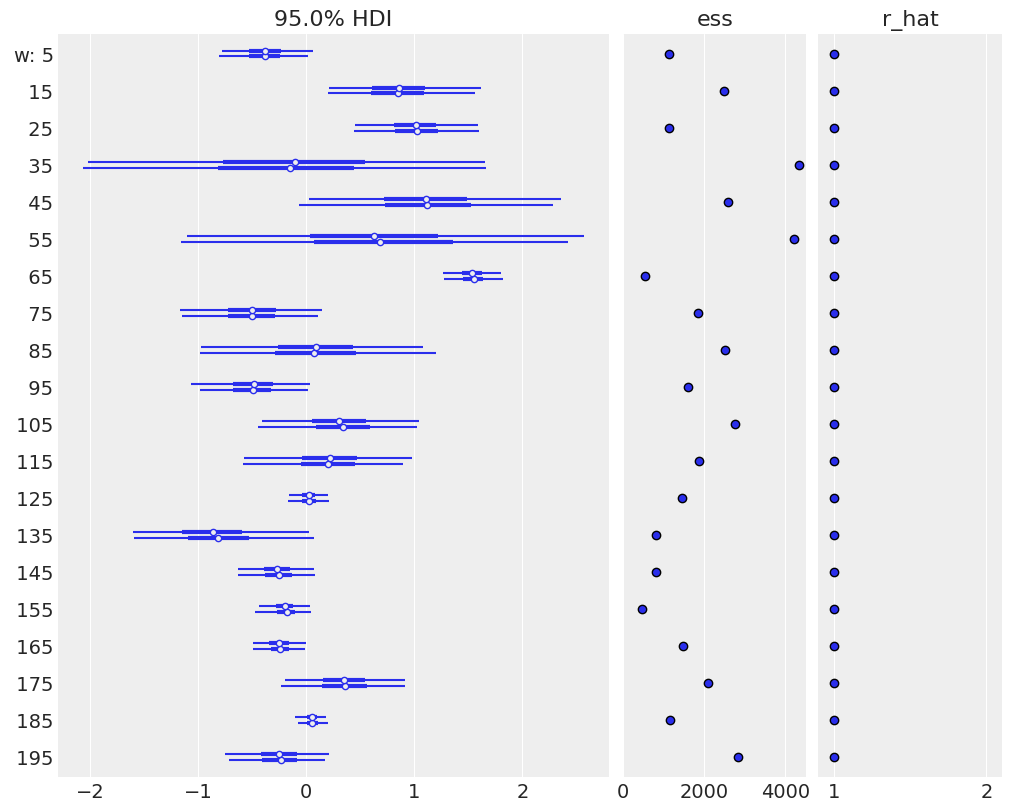

In [31]:
az.plot_forest(inf_data.posterior['w'][:,:,5::10], hdi_prob=0.95,
               r_hat=True, ess=True)

array([[<AxesSubplot:title={'center':'w\n10'}>,
        <AxesSubplot:title={'center':'w\n35'}>,
        <AxesSubplot:title={'center':'w\n60'}>,
        <AxesSubplot:title={'center':'w\n85'}>],
       [<AxesSubplot:title={'center':'w\n110'}>,
        <AxesSubplot:title={'center':'w\n135'}>,
        <AxesSubplot:title={'center':'w\n160'}>,
        <AxesSubplot:title={'center':'w\n185'}>]], dtype=object)

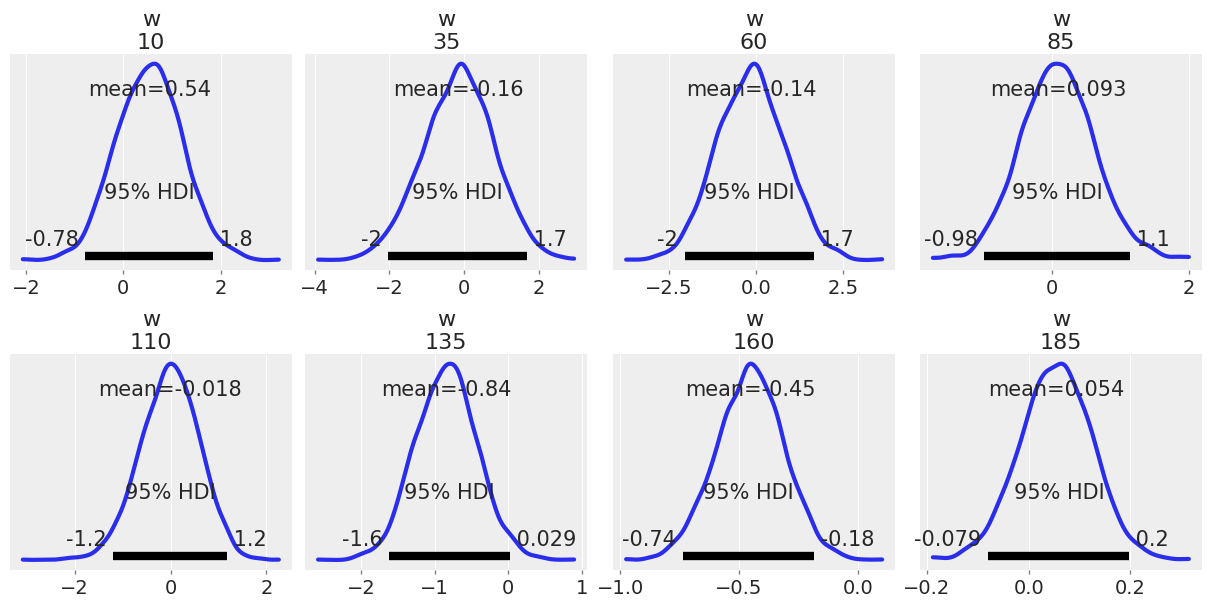

In [32]:
az.plot_posterior(inf_data.posterior['w'][:,:,10::25],var_names = ['w'], hdi_prob = 0.95, figsize = (12,6), lw = 3)

In [33]:
w_trace = inf_data.posterior['w'].values.reshape(4000,203)

For each column of features in `X_test.T`, multiplying it by rows from w_trace and taking the sigmoid, we obtain a column of the new matrix` ensemble` whose elements are predictions for the given object, that is, an ensemble of predictions, which only remains to average and get the final score for the given object. Doing this for each line in `ensemble` we get a vector of predictions for` X_test` 

In [34]:
ensemble = logistic.cdf(w_trace.dot(X_test.T))
ensemble.shape

(4000, 3832)

In [35]:
y_pred_pm = np.mean(ensemble, axis = 0)
metric_pm = roc_auc_score(y_test, y_pred_pm)
metric_pm

0.7804026154352902

in Bayesian methods, we get a sampled vector of model parameters. In other words, we have a huge number of model parameters, hence a huge number of models. Averaging the predictions of each model, we get better quality

In [36]:
pd.DataFrame({'MLE': [metric] , 'MCMC': [metric_pm]}, index = ['Metric'])

,MLE,MCMC
Metric,0.77945,0.780403
